# Motion Correction: SplineSG

This notebook sketches how splineSG works and how to implement it for motion correction.


In [1]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
from cedalion.sigproc.artifact import detect_baselineshift, detect_outliers
from cedalion.sigproc.motion_correct import motionCorrectSpline, motionCorrectSplineSG
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p
from functools import reduce


from cedalion import Quantity, units

Text(0, 0.5, 'Signal intensity / a.u.')

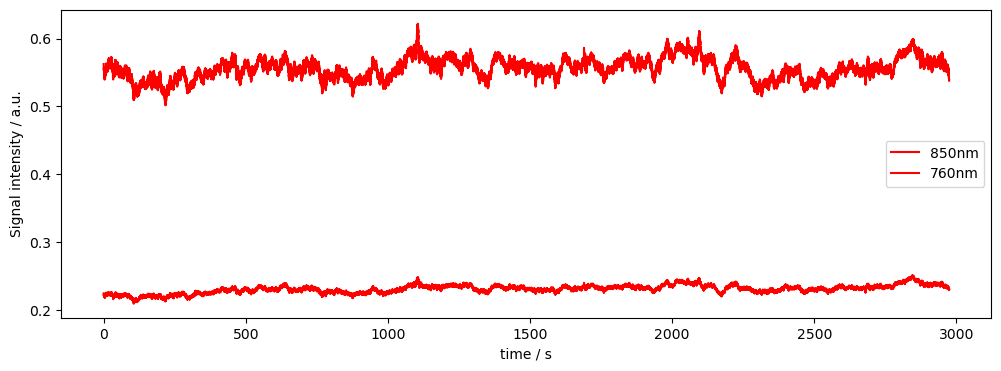

In [2]:
# get example finger tapping dataset
snirf_element = datasets.get_fingertapping()
amp = snirf_element[0].data[0]
geo = snirf_element[0].geo3d
od = cedalion.nirs.int2od(amp)

data = xr.Dataset(
    data_vars = {
        "amp" : amp,
        "od"  : od,
        "geo3d": geo
    })


# Plot some data for visual validation
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.amp.time, data.amp.sel(channel="S3D3", wavelength="850"), "r-", label="850nm")
ax.plot( data.amp.time, data.amp.sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

## Detecting outliers and baseline shifts

SplineSG has two stages. First, in the spline interpolation stage, baselineshifts are detected and spline interpolation is applied to these segments of the signal. Two functions are called initially, detect_outliers(), which returns a boolean mask containing False when outliers are detected and False otherwise, and detect_baselineshift(), which is passed the mask from detect_outliers and returns another mask that indicates where there are baseline shifts. Spline interpolation is then performed on the segments of data where baseline shifts are detected.

Text(0, 0.5, 'Optical density / a.u.')

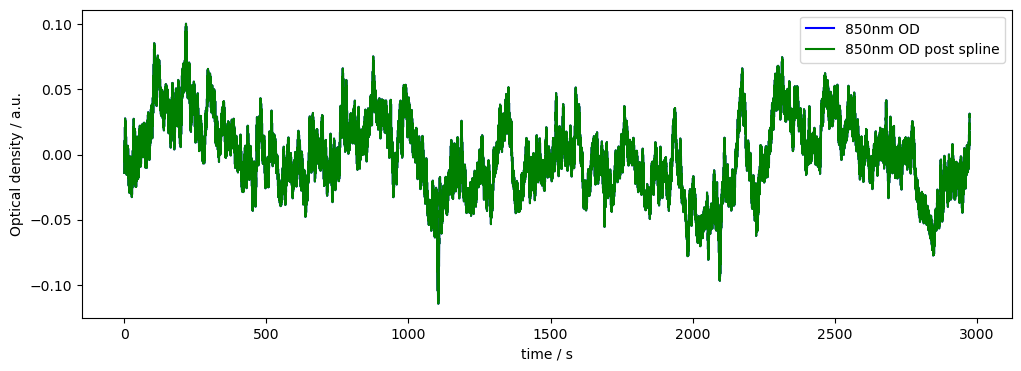

In [3]:
# call detect_outliers first 
# this returns mask, M, and M_array which is the result of applying the mask, M to the fNIRSdata
M, M_array = detect_outliers(fNIRSdata = data.od, t_motion = 1)

# call detect_baselineshifts
tInc, tIncCh = detect_baselineshift(fNIRSdata = data.od, M = M)

# perform spline interpolation
dodSpline = motionCorrectSpline(fNIRSdata=data.od, tIncCh=tIncCh)


# plot difference between uncorrected OD and after spline correction
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.od.time, data.od.sel(channel="S3D3", wavelength="850"), "b-", label="850nm OD")
ax.plot( dodSpline.time, dodSpline.sel(channel="S3D3", wavelength="850"), "g-", label="850nm OD post spline")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Optical density / a.u.")


## Savitzky-Golay filtering

The second stage applies a Savitzky-Golay filter to the data to further smooth the signal.

Text(0, 0.5, 'Optical density / a.u.')

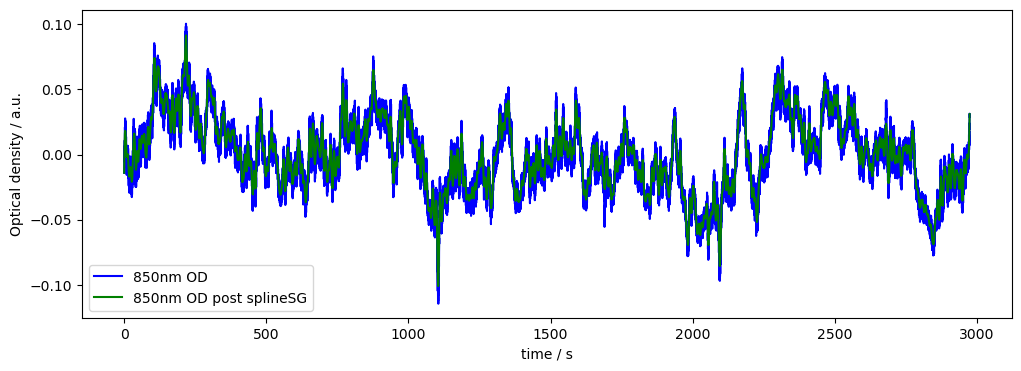

In [4]:
# the function motionCorrectSplineSG performs all the steps outlined above
dodSplineSG = motionCorrectSplineSG(fNIRSdata=data.od, framesize_sec=10)

# plot uncorrected data vs after splineSG motion correction 
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.od.time, data.od.sel(channel="S3D3", wavelength="850"), "b-", label="850nm OD")
ax.plot( dodSplineSG.time, dodSplineSG.sel(channel="S3D3", wavelength="850"), "g-", label="850nm OD post splineSG")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Optical density / a.u.")

